In [20]:
from time import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn import model_selection
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn import linear_model
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction import DictVectorizer
from scipy.stats import skew

import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# =================================================
# Import dataset
# =================================================
# Concatenate train and test (adding a flag) to
# factorize data preparation steps
train = pd.read_csv("../../../../mltestdata/04_house_prices/train.csv", index_col=0)
test = pd.read_csv("../../../../mltestdata/04_house_prices/test.csv", index_col=0)
train['train_test'] = 1
test['train_test'] = 0
y = np.log(train['SalePrice'])
x = pd.concat([train.drop(['SalePrice'], axis=1), test], axis=0)


In [21]:
# =================================================
# Data preparation
# =================================================
# Cast categorical features
categorical_feats = x.columns[x.dtypes == 'object'].tolist()
for col in categorical_feats:
    x[col].fillna('No', inplace=True)
    x[col] = x[col].astype("category")
# Fill Nan with median for numerical features
nan_feats = x.columns[~(x.dtypes == 'object') & (x.isnull().any())].tolist()
for col in nan_feats:
    x[col].fillna(x[col].median(), inplace=True)
# One-hot encoding
x_dummified = pd.get_dummies(x[categorical_feats])
for col in categorical_feats:
    del x[col]
x[x_dummified.columns] = x_dummified
# Unskew feature
numeric_feats = x.columns[x.dtypes != "object"].tolist()
skewed_feats = x[numeric_feats].apply(lambda c: skew(c.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index
x[skewed_feats] = np.log1p(x[skewed_feats])



In [22]:
# =================================================
# Grid search
# =================================================
# Search `alpha` regression parameters
x_train = x[x.train_test == 1]

Compute alpha = 1e-05 - 0.13304254311140573
Compute alpha = 1.6681005372000593e-05 - 0.131286532530758
Compute alpha = 2.782559402207126e-05 - 0.12949308441768723
Compute alpha = 4.641588833612782e-05 - 0.1271591364412418
Compute alpha = 7.742636826811278e-05 - 0.12486688948886923
Compute alpha = 0.0001291549665014884 - 0.12441477534625664
Compute alpha = 0.00021544346900318823 - 0.12601251242628392
Compute alpha = 0.00035938136638046257 - 0.13116254429061594
Compute alpha = 0.0005994842503189409 - 0.1424102187764055
Compute alpha = 0.001 - 0.15890375339348178


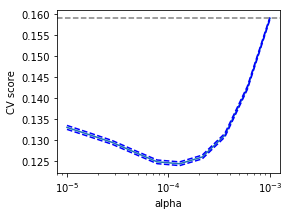

In [23]:
lasso = linear_model.Lasso(max_iter=1e2, normalize=True)
alphas = np.logspace(-5, -3, 10)
scores = []
scores_std = []
for alpha in alphas:
    lasso.alpha = alpha
    this_scores = np.sqrt(-model_selection.cross_val_score(lasso, x_train, y, cv=5, scoring='mean_squared_error'))
    print('Compute alpha = {} - {}'.format(alpha, np.mean(this_scores)))
    scores.append(np.mean(this_scores))
    scores_std.append(np.std(this_scores))
plt.figure(figsize=(4, 3))
plt.semilogx(alphas, scores)
plt.semilogx(alphas, np.array(scores) + np.array(scores_std) / np.sqrt(len(x_train)), 'b--')
plt.semilogx(alphas, np.array(scores) - np.array(scores_std) / np.sqrt(len(x_train)), 'b--')
plt.ylabel('CV score')
plt.xlabel('alpha')
plt.axhline(np.max(scores), linestyle='--', color='.5')
#plt.savefig('lasso_lars.png')

# =================================================
# Train, apply & submit
# =================================================
lasso.alpha = 0.0001291549665014884
lasso.fit(x_train, y) 
y_pred = lasso.predict(x[x.train_test == 0])
pd.DataFrame({'Id' : test.index, 'SalePrice': np.exp(y_pred)}).to_csv('submit_lasso.csv', index=False)

In [25]:
scores

[0.13304254311140573,
 0.131286532530758,
 0.12949308441768723,
 0.1271591364412418,
 0.12486688948886923,
 0.12441477534625664,
 0.12601251242628392,
 0.13116254429061594,
 0.1424102187764055,
 0.15890375339348178]

In [26]:
scores_std

[0.017904706819851193,
 0.017516067477632003,
 0.017131427110629711,
 0.016682756918267257,
 0.016633274001793739,
 0.016810416893363267,
 0.017004096544524273,
 0.016452358788956015,
 0.013804786310467792,
 0.010314985623068654]